# 1. Import Dependencies and Data

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\wolos\AppData\Local\Temp\pip-install-fg1j8s3w\tensorflow-gpu_c39346c37775419ba63e615a28dee068\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not build wheels for tensorflow-gpu, which is required to install pyproject.toml-

In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.6.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
babel                        2.16.0
beautifulsoup4               4.12.3
bleach                       6.1.0
certifi                      2024.7.4
cffi                         1.17.1
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.6
decorator                    5.1.1
defusedxml                   0.7.1
dm-tree                      0.1.8
docstring_parser             0.16
etils                        1.9.4



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\wolos\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
from matplotlib import pyplot as plt

In [5]:
import tensorflow as tf
import os

# Define the path to your images
image_dir = 'imagespng'

# Function to load and preprocess the images
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=1)  # Assuming the images are grayscale
    image = tf.image.resize(image, [32, 32])  # Resize to 32x32
    return image

# Get the list of image file paths
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.png')]

# Create a tf.data.Dataset for the images
ds_images = tf.data.Dataset.from_tensor_slices(image_paths)
ds_images = ds_images.map(load_and_preprocess_image)

# Create a label tensor with the same label for all images
# Replace 'your_label' with the desired label
label = tf.constant([1])  # Assuming '1' is the label you want to assign to all images
labels = tf.data.Dataset.from_tensor_slices(tf.fill([len(image_paths)], 1))  # Replace 1 with your desired label

# Combine images and labels into a single dataset
ds = tf.data.Dataset.zip((ds_images, labels))

# To access images and labels
for image, label in ds.take(5):  # Take the first 5 samples
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())


Image shape: (32, 32, 1)
Label: 1
Image shape: (32, 32, 1)
Label: 1
Image shape: (32, 32, 1)
Label: 1
Image shape: (32, 32, 1)
Label: 1
Image shape: (32, 32, 1)
Label: 1


In [6]:
data, label = ds.as_numpy_iterator().next()
print(label)

1


# 2. Viz Data and Build Dataset

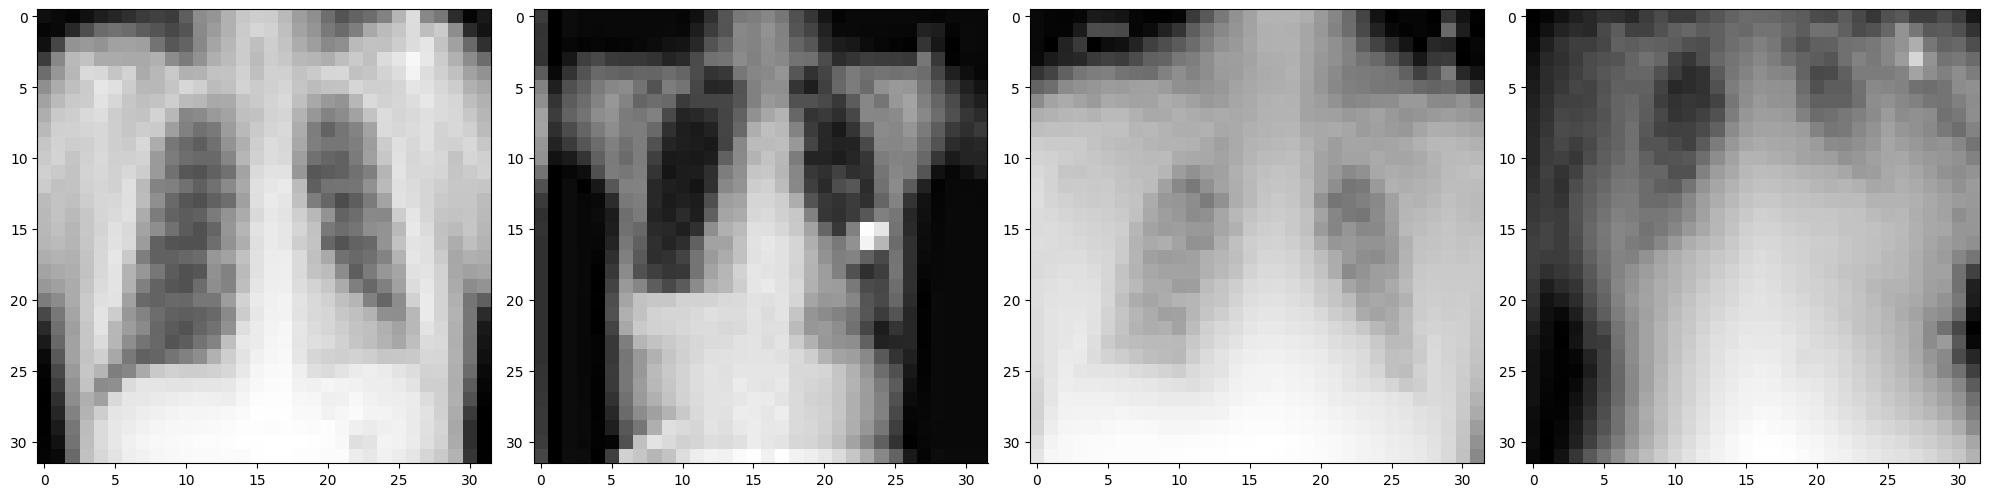

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Setup the subplot formatting
fig, axes = plt.subplots(ncols=4, figsize=(20, 20))

# Convert the dataset to a list of samples
dataiterator = ds.as_numpy_iterator()
samples = list(dataiterator)  # Create a list of all samples (images and labels)

# Randomly select 16 samples
random_samples = random.sample(samples, 4)

# Loop through the randomly selected samples and plot
for idx, ax in enumerate(axes.flat):  # Use .flat to iterate over the 4x4 grid
    image, label = random_samples[idx]  # Unpack the tuple into image and label

    # Plot the image using the specific subplot
    ax.imshow(np.squeeze(image), cmap='gray')  # Use cmap='gray' for grayscale images

plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot


In [8]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [9]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [10]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(8*8*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [11]:
generator = build_generator()

C:\Users\wolos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,402,817 (9.17 MB)

 Trainable params: 2,402,817 (9.17 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
img = generator.predict(np.random.randn(4,128,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


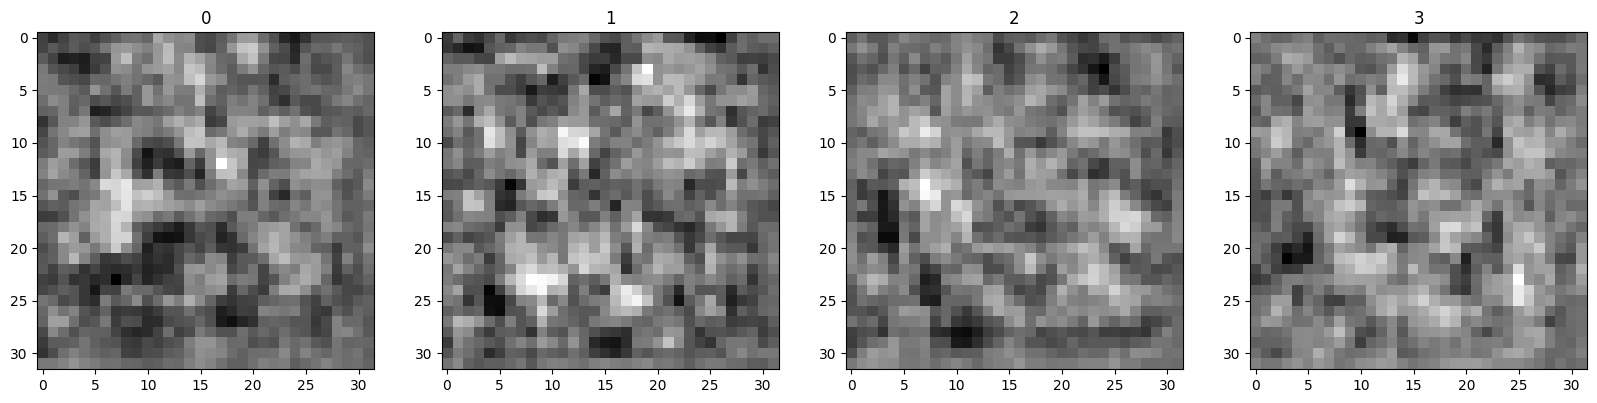

In [14]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img), cmap='gray')
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [15]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (32,32,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [16]:
discriminator = build_discriminator()

C:\Users\wolos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          65,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,017 (4.36 MB)

 Trainable params: 1,142,017 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
img = img[0]

In [19]:
img.shape

(32, 1)

In [20]:
# Assuming `img` is a numpy array of shape (32, 32)
img = np.random.rand(32, 32).astype(np.float32)  # Example input, replace with your actual image
img = img.reshape((1, 32, 32, 1))  # Reshape to (1, 32, 32, 1)

# Make a prediction with the discriminator
output = discriminator.predict(img)
print(output)
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
[[0.5013582]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.5013582]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [21]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [22]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [23]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [24]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real) * 0.9, tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [25]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [26]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [27]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [28]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train 

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

### 4.4 Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')